In [1]:
%pylab notebook

# Run on CPU not GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
from tensorflow.keras import layers

from primo.models.cas9_keras import log10_crispr_spec

import primo.models
import primo.datasets
import primo.tools.filepath as filepaths
import primo.tools.sequences as seqtools
import pandas as pd


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-am00y_sh because the default path (/tf/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load the model to be examined
encoder_20 = tf.keras.models.load_model('/tf/primo/data/models/encoder_singlesite_model.h5')
# encoder_80 = tf.keras.models.load_model('/tf/primo/data/models/encoder_4site_model.h5')
encoder_80 = tf.keras.models.load_model('/tf/primo/data/models/encoder_4site_model_20220630.h5')
encoder_20.compile()
encoder_80.compile()

In [3]:
### 
# Define utilities
###
def make_multisite_predictor(predictor):
    """Return a function that will predict multiple sites using the predictor
    function provided to score each
    
    Combined probability is 1 - (1 - P(site1)) * (1 - P(site2)) ... * (1 - P(siteN))
    """
    def multisite_predict(seq_pairs):
        n_sites = int(seq_pairs.shape[2] / 20)
        # Split into separate sites
        sites = tf.stack(tf.split(seq_pairs, n_sites, axis=2))
        # Apply predictor to sites independently
        scores = tf.map_fn(tf.function(predictor), sites)
        #scores *= tf.sqrt(tf.reduce_mean(tf.reduce_max(seq_pairs, axis=-1)))
        # Compute combined probability|
        #return tf.reduce_max(scores, axis=0)
        #return 2 * (tf.sigmoid(3*tf.sqrt(tf.reduce_sum(scores, axis=0))) - 0.5)
        return 1 - tf.reduce_prod(1 - scores, axis=0)
    return multisite_predict

def log_multisite_predictor(seq_pairs):
    n_sites = int(seq_pairs.shape[2] / 20)
    # Split into separate sites
    sites = tf.stack(tf.split(seq_pairs, n_sites, axis=2))
    # Apply predictor to sites independently
    scores = tf.map_fn(tf.function(log10_crispr_spec), sites)
    linear_scores = 10**scores
    return tf.experimental.numpy.log10(tf.reduce_sum(linear_scores, axis=0))

def confidence_by_base(sequences):
    """Takes a batch of softmax sequences, and returns vector of average confidence in each position
    
    sequences: Number of exmaple x Number of bases x 4
    
    Returns: 1 x number of bases
    """
    # reduce last dimension to max base number
    return np.mean(np.max(sequences, axis=-1), axis=0)

def entropy_by_base(sequences):
    x = np.sum(sequences, axis=0)
    x /= np.sum(x, axis=1)[:, None]
    entropy = -np.sum(x * np.log(x + 1e-10), axis=1)
    return entropy

def base_distribution(sequences):
    one_hots = one_hot(sequences)
    bases = np.sum(one_hots, axis=0)

def one_hot(nparray, depth = 0, on_value = 1, off_value = 0):
    if depth == 0:
        depth = np.max(nparray) + 1
    assert np.max(nparray) < depth, "the max index of nparray: {} is larger than depth: {}".format(np.max(nparray), depth)
    shape = nparray.shape
    out = np.ones((*shape, depth), dtype=np.float32) * off_value
    indices = []
    for i in range(nparray.ndim):
        tiles = [1] * nparray.ndim
        s = [1] * nparray.ndim
        s[i] = -1
        r = np.arange(shape[i]).reshape(s)
        if i > 0:
            tiles[i-1] = shape[i-1]
            r = np.tile(r, tiles)
        indices.append(r)
    indices.append(nparray)
    out[tuple(indices)] = on_value
    return out

def get_multiple_batchs(n, generator):
    indices = None
    values = None
    for _ in range(n):
        i, v = next(generator)
        if indices is None:
            indices = i
            values = v
        else:
            indices = np.concatenate([indices, i])
            values = np.concatenate([values, v])
    return indices, values

In [4]:
###
# Load queries and see what they encode to
###
query_features_filepath = filepaths.get_query_features_path(isDocker=True)
query_features = pd.read_hdf(query_features_filepath)
query_seqs = seqtools.onehots_to_seqs(encoder_20.predict(query_features))
print(f"Query Seqs: \n" + "\n".join(query_seqs))

def seq_str_to_input(seq):
    return np.transpose(seqtools.seqs_to_onehots(seq), [1, 0, 2])

query_features_filepath = filepaths.get_query_features_path(isDocker=True)
query_features = pd.read_hdf(query_features_filepath)
query_seqs = seqtools.onehots_to_seqs(encoder_80.predict(query_features))
print(f"Query Seqs: \n" + "\n".join(query_seqs))

def seq_str_to_input(seq):
    return np.transpose(seqtools.seqs_to_onehots(seq), [1, 0, 2])

Query Seqs: 
ATGTCAGACGCTAAAATGAA
ATGTCAGACGCTAAAATGAA
AAGCCAAACGCCAAAATGAA
Query Seqs: 
CCTTGAATCTAACACACGGAAACGGGAGCTGGTAAGCGTGAACGTAGCGCCCAGGCAGATATCCAATGTAAGAGAGTACG
CCTTGAATACCAGTGATGAAAACGGGAGCTGGTAAGCGTGACAGGATCGCCCAAGTAATTTTCCAGCGTAGGCGAGTAGG
CCGGAAGTTTATGTGATGAAACGCAAAGATGGTAAGCGTGTAATGCCCTCGAAAGCAGATTTTCAGTGTAGACGATAAGG


In [5]:
###
# Use data batch generators to get a batch of random training and validation
# data

def keras_batch_generator(dataset_batch_generator, similarity_threshold):
    # Yield datasets
    while True:
        indices, pairs = next(dataset_batch_generator)
        # The Euclidean distances between the two vectors in each pair
        distances = np.sqrt(np.square(pairs[:,0,:] - pairs[:,1,:]).sum(1))
        # Whether or not the images in this pair should be considered 'similar'. This is a boolean value, represented by an int (0 or 1), and is determined by whether the aforementioned Euclidean distances between image feature vectors are under some pre-deterined "similarity threshold".
        similar = (distances < similarity_threshold).astype(int)
        # Yield a pair of sequences, and 0-or-1 indicating whether they're similar.
        yield pairs, similar
        
batch_size = 200
similarity_threshold = 75

validation_dataset = primo.datasets.OpenImagesVal('/tf/open_images/validation/')

# Generators for balanced pairs
val_pair_generator = keras_batch_generator(
    validation_dataset.balanced_pairs(batch_size, similarity_threshold), 
    similarity_threshold)

# Get pairs (50 batches x 200 batch size = 10k pairs)
val_feat_pairs, val_truth = get_multiple_batchs(50, val_pair_generator)


<IPython.core.display.Javascript object>


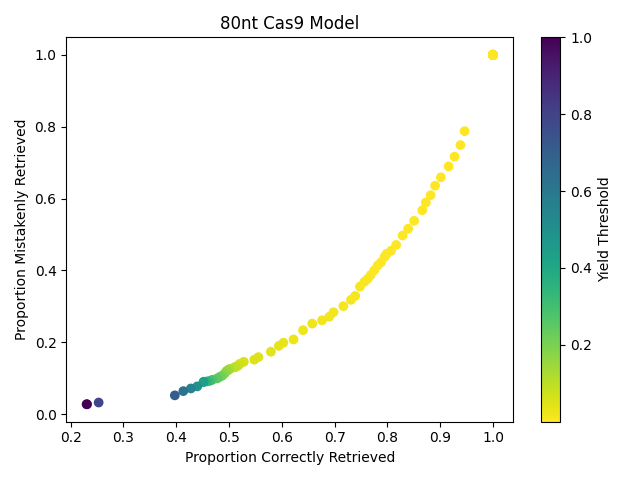

In [7]:
# Encode sequence pairs with the 1 site, 20 nt cas9 encoder
# val_seq_pairs = one_hot(np.stack([
#     encoder_20.predict(val_feat_pairs[:, 0, :]).argmax(-1),
#     encoder_20.predict(val_feat_pairs[:, 1, :]).argmax(-1),
# ], axis=1)).astype(np.float32)

# Encode sequence pairs with the 4 site, 80 nt cas9 encoder
val_seq_pairs = one_hot(np.stack([
    encoder_80.predict(val_feat_pairs[:, 0, :]).argmax(-1),
    encoder_80.predict(val_feat_pairs[:, 1, :]).argmax(-1),
], axis=1)).astype(np.float32)


# split pairs into positive (similar) and negative (dissimilar) pairs
pairs_p = val_seq_pairs[val_truth > 0.5] #onehot vectors similar
pairs_n = val_seq_pairs[val_truth < 0.5] #onehot vectors dissimilar


# Compute the log10 scores for positive (similar) and negative (dissimilar) pairs
# modify each value with 10**n to scale between 0 and 1
Yp_yield = 10**(log_multisite_predictor(pairs_p).numpy())
Yn_yield = 10**(log_multisite_predictor(pairs_n).numpy())

recall_data = []
false_positive_data = []

# thresholds=np.linspace(0, 1, 100)
thresholds=np.logspace(-5, 0, 100)

for t in thresholds:
    recall = (Yp_yield > t).mean()
    false_positive = (Yn_yield > t).mean()
    recall_data.append(recall)
    false_positive_data.append(false_positive)
    
plt.figure()   
plt.scatter(recall_data, false_positive_data, c=thresholds, cmap=plt.cm.viridis_r)
plt.xlabel("Proportion Correctly Retrieved")
plt.ylabel("Proportion Mistakenly Retrieved")
plt.colorbar(label="Yield Threshold")
# plt.title("20nt Cas9 Model")
plt.title("80nt Cas9 Model")
plt.tight_layout()
# plt.savefig('20_cas9_retrieval_random_pair_simulations.png', bbox_inches='tight', dpi=1000)
plt.show()
plt.savefig('80_cas9_retrieval_random_pair_simulationsjuly.png', bbox_inches='tight', dpi=1000)


In [19]:
print(recall_data)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9828034393121375, 0.9824035192961408, 0.982003599280144, 0.9816036792641472, 0.981003799240152, 0.981003799240152, 0.9802039592081584, 0.9798040391921615, 0.979004199160168, 0.9734053189362127, 0.9652069586082783, 0.9634073185362927, 0.9500099980003999, 0.9462107578484303, 0.943011397720456, 0.936612677464507, 0.9206158768246351, 0.9104179164167167, 0.9034193161367726, 0.8740251949610078, 0.8604279144171165, 0.8452309538092382, 0.8350329934013198, 0.8280343931213757, 0.8262347530493901, 0.8182363527294542, 0.8170365926814637, 0.8120375924815036, 0.8090381923615277, 0.8060387922415517, 0.8036392721455708, 0.7986402719456108, 0.793241351729654, 0.7888422315536893, 0.7846430713857229, 0.7736452709458108, 0.7640471905618876, 0.7596480703859229, 0.7506498700259948, 0.7434513097380524, 0.734253149370126, 0.7306538692261547, 0.7196560687862428, 0.711057788442311

In [8]:
val_seq_pairs

array([[[[0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.],
         ...,
         [1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [0., 0., 1., 0.]],

        [[0., 1., 0., 0.],
         [0., 0., 0., 1.],
         [0., 1., 0., 0.],
         ...,
         [0., 1., 0., 0.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.]]],


       [[[0., 0., 1., 0.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         ...,
         [1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.]],

        [[0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.],
         ...,
         [1., 0., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]],


       [[[0., 0., 1., 0.],
         [1., 0., 0., 0.],
         [0., 0., 0., 1.],
         ...,
         [1., 0., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]],

        [[1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 0., 1.],
         ...,
         [1

In [5]:
###
# Use data batch generators to get a batch of random training and validation
# data
###encoder_1site_triplet_20220128_1

def keras_batch_generator(dataset_batch_generator, similarity_threshold):
    # Yield datasets
    # TODO: Verify with Callie this understanding is correct https://github.com/uwmisl/cas9-similarity-search/issues/2
    while True:
        # This tuple contains:
        # indices: a positive integer uniquely identifying an image. This index is obtained by enumerating all the images in the dataset (before splitting them into test/train/validate datasets)
        # pairs:
        indices, pairs = next(dataset_batch_generator)
        # The Euclidean distances between the two vectors in each pair
        distances = np.sqrt(np.square(pairs[:,0,:] - pairs[:,1,:]).sum(1))
        # Whether or not the images in this pair should be considered 'similar'. This is a boolean value, represented by an int (0 or 1), and is determined by whether the aforementioned Euclidean distances between image feature vectors are under some pre-deterined "similarity threshold".
        similar = (distances < similarity_threshold).astype(int)
        # Yield a pair of sequences, and 0-or-1 indicating whether they're similar.
        yield pairs, similar

batch_size = 200
similarity_threshold = 75
train_dataset = primo.datasets.OpenImagesTrain(
    '/tf/open_images/train/', switch_every=10**5
)
validation_dataset = primo.datasets.OpenImagesVal('/tf/open_images/validation/')
 
# # Generator for triplets
# train_triplet_generator = primo.datasets.dataset.triplet_batch_generator(
#     train_dataset.random_features(batch_size),
#     similarity_threshold
# )

# val_triplet_generator = primo.datasets.dataset.triplet_batch_generator(
#     validation_dataset.random_features(batch_size),
#     similarity_threshold
# )

# Generators for balanced pairs
train_pair_generator = keras_batch_generator(
    train_dataset.balanced_pairs(batch_size, similarity_threshold),
    similarity_threshold
)
val_pair_generator = keras_batch_generator(
    validation_dataset.balanced_pairs(batch_size, similarity_threshold),
    similarity_threshold
)

# batch = next(batch_generator)
# del batch_generator

# val_batch = next(encoder_val_batches)
# del encoder_val_batches

Now, plot a scatterplot where random pairs of similar and dissimilar images are paired and their score is plotted.

recall: 0.80, false_positive: 0.45


<IPython.core.display.Javascript object>


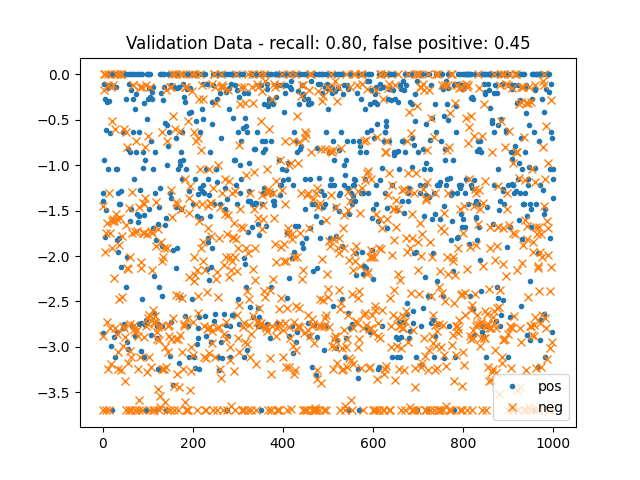

recall: 0.77, false_positive: 0.37


<IPython.core.display.Javascript object>


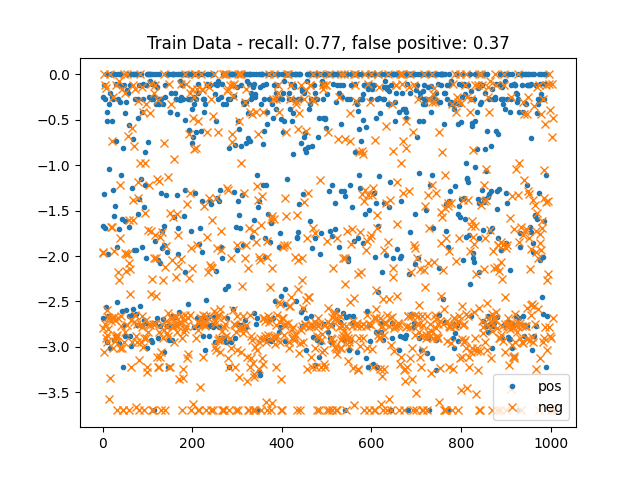

In [8]:
def plot_pair_scatter(seq_pairs, y_true, title):
    pairs_p = seq_pairs[y_true > 0.5] # similar pairs
    pairs_n = seq_pairs[y_true < 0.5] # dissimilar pairs
    # Compute the log10 scores for positive (similar) pairs
    Yp = log_multisite_predictor(pairs_p).numpy()
    # Compute the log10 score for negative (dis-similar) pairs
    Yn = log_multisite_predictor(pairs_n).numpy()

    recall = (Yp > -2.0).mean()
    false_positive = (Yn > -2.0).mean()
    print(f"recall: {recall:.2f}, false_positive: {false_positive:.2f}")

    plt.figure()
    plt.plot(Yp, '.', label='pos')
    plt.plot(Yn, 'x', label='neg')
    plt.legend()
    plt.title(f'{title} - recall: {recall:0.2f}, false positive: {false_positive:0.2f}')

val_feat_pairs, val_truth = get_multiple_batchs(10, val_pair_generator)
val_seq_pairs = one_hot(np.stack([
    encoder.predict(val_feat_pairs[:, 0, :]).argmax(-1),
    encoder.predict(val_feat_pairs[:, 1, :]).argmax(-1),
], axis=1)).astype(np.float32)

train_feat_pairs, train_truth = get_multiple_batchs(10, train_pair_generator)
train_seq_pairs = one_hot(np.stack([
    encoder.predict(train_feat_pairs[:, 0, :]),
    encoder.predict(train_feat_pairs[:, 1, :]),
], axis=1).argmax(-1))

plot_pair_scatter(val_seq_pairs, val_truth, 'Validation Data')
plot_pair_scatter(train_seq_pairs, train_truth, 'Train Data')

In [9]:
### Sequence Confidence and Variation
#
# Get a random set of validation features and encode to sequences, then 
# plot the confidence and variation (entropy) of the sequence pool
# for each sequence position. 

_, example_features = next(validation_dataset.random_features(500))
seqs_softmax = encoder.predict(example_features)
seqs_onehot = one_hot(seqs_softmax.argmax(-1))

unique_seqs = np.unique(seqs_onehot, axis=0)
sequence_uniqueness = len(unique_seqs) / len(seqs_onehot)

base_distributions = seqs_onehot.sum(0) / len(seqs_onehot)
seqlen = seqs_onehot.shape[1]

confidence = confidence_by_base(seqs_softmax)
entropy = entropy_by_base(seqs_softmax)

seqlen = seqs_softmax.shape[1]
fig = plt.figure(figsize=[7, 7])
fig.suptitle(f'Sequence Uniqueness = {sequence_uniqueness:0.2f}')
axes = fig.subplots(3,1)

ax = axes[0]
ax.bar(np.arange(0, seqlen), confidence)
ax.set_title('confidence')

ax = axes[1]
ax.bar(np.arange(0, seqlen), entropy)
ax.set_title('entropy')

ax = axes[2]
ax.set_title('base distribution')
ax.set_xlabel('sequence position')
bottom = np.zeros_like(base_distributions[:, 0])
ax.bar(np.arange(seqlen), base_distributions[:, 0], label='A', )
bottom += base_distributions[:, 0]
ax.bar(np.arange(seqlen), base_distributions[:, 1], label='T', bottom=bottom)
bottom += base_distributions[:, 1]
ax.bar(np.arange(seqlen), base_distributions[:, 2], label='C', bottom=bottom)
bottom += base_distributions[:, 2]
ax.bar(np.arange(seqlen), base_distributions[:, 3], label='G', bottom=bottom)
ax.legend(bbox_to_anchor=(1.15, 0.9))

plt.tight_layout()

NameError: name 'encoder' is not defined